In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.utils import pad_sequences, to_categorical
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D, Input, Activation
from keras.models import Sequential

In [5]:
!unzip /content/data/dataset.zip

Archive:  /content/data/dataset.zip
  inflating: imbalanced_data.csv     
  inflating: raw_data.csv            


In [6]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',255)

In [8]:
imbalanced_data = pd.read_csv('imbalanced_data.csv')

In [9]:
imbalanced_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [11]:
imbalanced_data['label'].unique()

array([0, 1])

In [15]:
imbalanced_data.isnull().sum()

,0
id,0
label,0
tweet,0


<ipython-input-19-fae27abc959c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label',data=imbalanced_data, palette=['blue','orange'])


<Axes: xlabel='label', ylabel='count'>

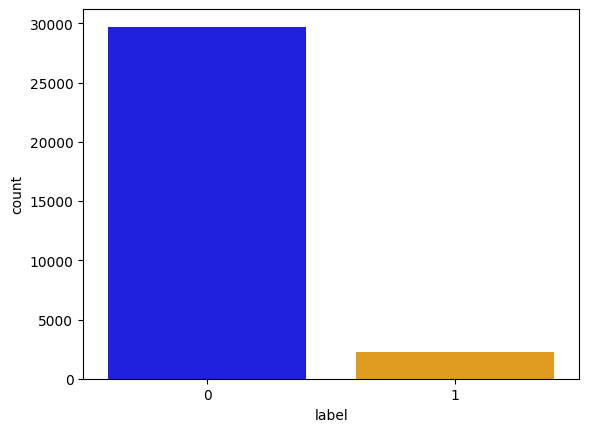

In [19]:
sns.countplot(x='label',data=imbalanced_data, palette=['blue','orange'])

In [20]:
imbalanced_data.drop(axis=1,columns=['id'],inplace=True)

In [21]:
imbalanced_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


In [22]:
raw_data = pd.read_csv('raw_data.csv')

In [23]:
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [24]:
raw_data['class'].unique()

array([2, 1, 0])

<ipython-input-26-fd913d4c9cc1>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class',data=raw_data, palette=['blue','orange','green'])


<Axes: xlabel='class', ylabel='count'>

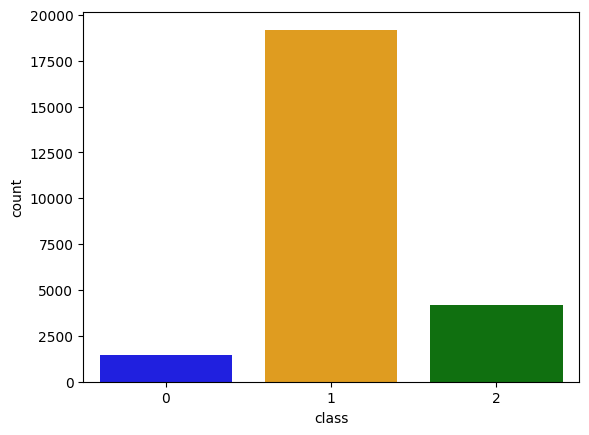

In [26]:
sns.countplot(x='class',data=raw_data, palette=['blue','orange','green'])

In [27]:
raw_data.isnull().sum()

,0
Unnamed: 0,0
count,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


In [28]:
raw_data.drop(axis=1,columns=['Unnamed: 0','count','hate_speech','offensive_language','neither'],inplace=True)

In [29]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


<Axes: xlabel='class', ylabel='count'>

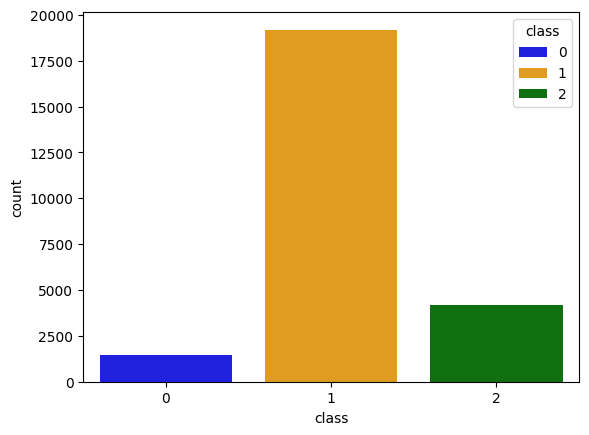

In [33]:
sns.countplot(x='class',data=raw_data, palette=['blue','orange','green'],hue='class',legend=True)

In [34]:
raw_data[raw_data['class']==0]['class']=1

<ipython-input-34-55e395ab275c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[raw_data['class']==0]['class']=1


In [35]:
raw_data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [37]:
raw_data['class'].unique()

array([2, 1, 0])

In [38]:
raw_data['tweet'].duplicated().sum()

np.int64(0)

In [39]:
imbalanced_data['tweet'].duplicated().sum()

np.int64(2432)

In [40]:
imbalanced_data = imbalanced_data.drop_duplicates()

In [42]:
imbalanced_data['tweet'].duplicated().sum()

np.int64(0)

In [43]:
raw_data[raw_data['class']==0]

,class,tweet
85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer"" gaywad"
89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a beaner smh you can tell hes a mexican"
110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, blacklisted hoe"" Holding out for #TehGodClan anyway http://t.co/xUCcwoetmn"
184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPLE https://t.co/RNvD2nLCDR"" This is why there's black people and niggers"
202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http://t.co/RGJa7CfoiT""\n\nLmfao"
204,0,"""@NotoriousBM95: @_WhitePonyJr_ Ariza is a snake and a coward"" but at least he isn't a cripple like your hero Roach lmaoo"
219,0,"""@RTNBA: Drakes new shoes that will be released by Nike/Jordan.... Yes, there's glitter on the shoes http://t.co/QCtPLxHEXM"" ....dudes a fag"
260,0,"""@TheoMaxximus: #GerrysHalloweenParty http://t.co/3ycrSrnjHc"" Halloween was yesterday stupid nigger"
312,0,"""@ashlingwilde: @ItsNotAdam is bored supposed to be cute, you faggot?"" Sometimes"
315,0,"""@bigbootybishopp: @white_thunduh lassen cc , the coach wants me"" i feel it youll get more my nig no doubt"


In [44]:
raw_data['class'].replace({0:1},inplace=True)

<ipython-input-45-d669d7fbbe40>:1: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(x='class',data=raw_data, palette=['blue','orange','green'],hue='class',legend=True)


<Axes: xlabel='class', ylabel='count'>

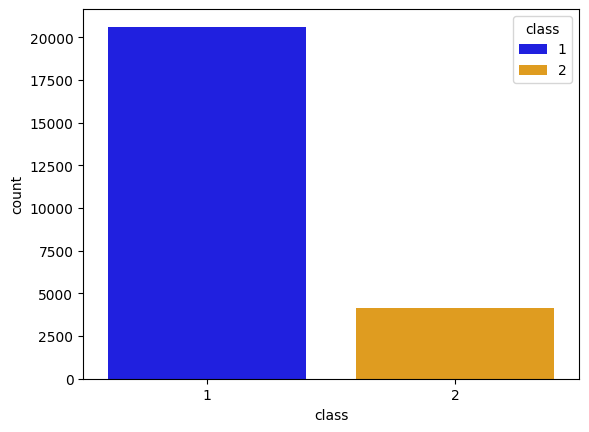

In [45]:
sns.countplot(x='class',data=raw_data, palette=['blue','orange','green'],hue='class',legend=True)

In [46]:
raw_data['class'].replace({2:0},inplace=True)

<ipython-input-47-d669d7fbbe40>:1: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(x='class',data=raw_data, palette=['blue','orange','green'],hue='class',legend=True)


<Axes: xlabel='class', ylabel='count'>

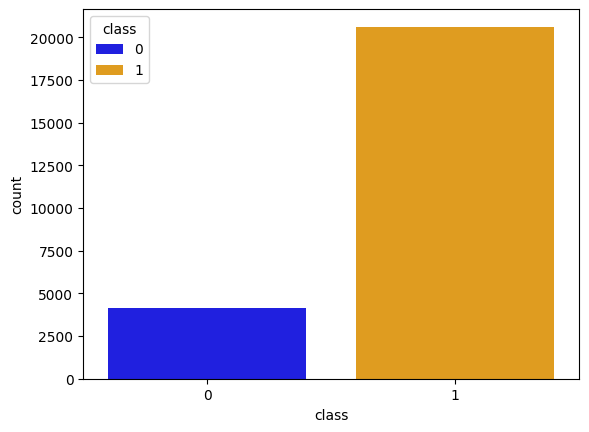

In [47]:
sns.countplot(x='class',data=raw_data, palette=['blue','orange','green'],hue='class',legend=True)

In [50]:
raw_data.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [55]:
raw_data.iloc[0]['tweet']

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [59]:
raw_data.rename(columns={'class':'label'},inplace=True)

In [60]:
frame = [imbalanced_data, raw_data]

In [61]:
df = pd.concat(frame)

In [62]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


<ipython-input-63-78a4096043aa>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label',data=df, palette=['blue','orange'])


<Axes: xlabel='label', ylabel='count'>

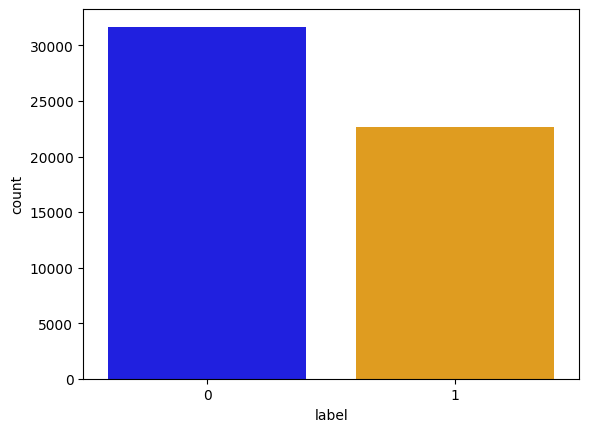

In [63]:
sns.countplot(x='label',data=df, palette=['blue','orange'])

In [64]:
df.shape

(54313, 2)

In [65]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [66]:
stemmer = nltk.SnowballStemmer("english")

In [67]:
stopword = set(stopwords.words('english'))

In [68]:
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [69]:
df['tweet'] = df['tweet'].apply(data_cleaning)

In [70]:
df['tweet'][1]

,tweet
1,user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthank user user thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx disapointed getthank user user thanks for lyft...
1,rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac...


In [71]:
x = df['tweet']
y = df['label']

In [73]:
X_train,X_test,y_train,y_test = train_test_split(x,y,random_state=42)

In [75]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

40734 40734
13579 13579


In [76]:
type(X_test), type(y_test), type(X_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [78]:
max_words = 50000
max_len = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
sequence_matrix = pad_sequences(sequences, maxlen=max_len)

In [79]:
sequence_matrix

array([[   18,   190,   717, ...,   321,   527, 11378],
       [    0,     0,     0, ...,    16,    24, 25036],
       [  421,    40,     2, ...,   447,   825,  2152],
       ...,
       [    0,     0,     0, ...,     2,   556,   112],
       [    0,     0,     0, ...,     3, 33292,  1568],
       [    0,     0,     0, ...,  1201,    51,    18]], dtype=int32)

In [80]:
model = Sequential()

model.add(Embedding(max_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [81]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:
history = model.fit(sequence_matrix, y_train, batch_size=128, epochs=1, validation_split=0.2)

255/255 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9453 - loss: 0.1572 - val_accuracy: 0.9397 - val_loss: 0.1660


In [84]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequence_matrix = pad_sequences(test_sequences, maxlen=max_len)

In [85]:
accr = model.evaluate(test_sequence_matrix, y_test)

425/425 ━━━━━━━━━━━━━━━━━━━━ 80s 188ms/step - accuracy: 0.9409 - loss: 0.1671


In [86]:
lstm_prediction = model.predict(test_sequence_matrix)

425/425 ━━━━━━━━━━━━━━━━━━━━ 78s 182ms/step


In [87]:
res = []

for prediction in lstm_prediction:
  if prediction > 0.5:
    res.append(1)
  else:
    res.append(0)

In [89]:
from sklearn.metrics import confusion_matrix

In [91]:
print(confusion_matrix(y_test,res))

[[7561  349]
 [ 470 5199]]


In [92]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
model.save("model.h5")

In [94]:
import keras

In [95]:
load_model = keras.models.load_model('model.h5')

In [99]:
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [104]:
test = 'i love this movie'

def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [105]:
test=[clean_text(test)]
print(test)

seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)

pred = load_model.predict(padded)

print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")


i love this movie
i love this movie
['love movi']
[[34, 5223]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
pred [[0.14316213]]
no hate
